In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/stage1_train.zip","r") as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Open_Source_Dataset")

In [3]:
#https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [4]:
image_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images'
groundtruth_path='/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth'

In [5]:
img_id=[]
for image in os.listdir(image_path):
  img_id.append(image)
  #print(img_id)
img_id.sort()
print(img_id)

['.ipynb_checkpoints', '01_1.png', '01_2.png', '01_3.png', '01_4.png', '01_5.png', '01_6.png', '01_7.png', '02_1.png', '02_2.png', '02_3.png', '03_1.png', '03_2.png', '03_3.png', '03_4.png', '03_5.png', '04_1.png', '04_2.png', '04_3.png', '04_4.png', '04_5.png', '04_6.png', '04_7.png', '04_8.png', '05_1.png', '05_2.png', '05_3.png', '05_4.png', '06_1.png', '06_2.png', '06_3.png', '07_1.png', '07_2.png', '07_3.png', '08_1.png', '08_2.png', '08_3.png', '08_4.png', '09_1.png', '09_2.png', '09_3.png', '09_4.png', '09_5.png', '09_6.png', '10_1.png', '10_2.png', '10_3.png', '10_4.png', '11_1.png', '11_2.png', '11_3.png']


In [6]:
image_size=128

In [7]:
from google.colab.patches import cv2_imshow

In [8]:
test_imgs=[]
for img in img_id:
  path=image_path+'/'+img
  image = cv2.imread(path, 1)
  #cv2_imshow(image)
  try:
    image = cv2.resize(image, (image_size, image_size))
    print(image.shape)
  except:
    break
  image = image/255.0
  test_imgs.append(image)
  
test_imgs=np.array(test_imgs)
print(test_imgs.shape)

(0,)


In [9]:
test_masks=[]
for img in img_id:
  path=groundtruth_path+'/'+img
  image = cv2.imread(path, 0)
  #cv2_imshow(image)
  try:
    image = cv2.resize(image, (image_size, image_size))
    print(image.shape)
  except:
    break
  image = image/255.0
  test_masks.append(image)
  
test_masks=np.array(test_masks)
print(test_masks.shape)

(0,)


In [10]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [11]:
image_size = 128
train_path = "/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Open_Source_Dataset"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [12]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


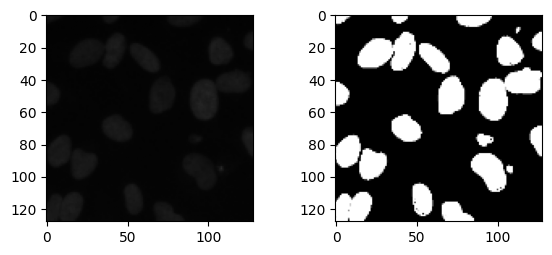

In [13]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [14]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [15]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [16]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

<ipython-input-17-36281b7dec54>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps,


Epoch 1/5
11/82 [===>..........................] - ETA: 1:36:03 - loss: 0.6231 - acc: 0.8421

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size,1)), cmap="gray")

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size,1)), cmap="gray")

In [ ]:
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(r"/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images/01_1.png") 
  
# This method will show image in any image viewer 
im.show() 

pix = np.array(im)

In [ ]:
res = model.predict(test_imgs)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(test_masks[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(res[1]*255, (image_size, image_size,1)), cmap="gray")

#Testing stain colour normalisation

In [ ]:
!pip install histomicstk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 KB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.6/633.6 KB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.1 MB/s eta 0:00:00
INFO: pip is looki

In [2]:
import numpy as np
from matplotlib.colors import ListedColormap

from histomicstk.preprocessing import color_conversion


def reinhard(
        im_src, target_mu, target_sigma, src_mu=None, src_sigma=None,
        mask_out=None):
    """Perform Reinhard color normalization.
    Transform the color characteristics of an image to a desired standard.
    The standard is defined by the mean and standard deviations of the target
    image in LAB color space defined by Ruderman. The input image is converted
    to Ruderman's LAB space, the LAB channels are each centered and scaled to
    zero-mean unit variance, and then rescaled and shifted to match the target
    image statistics. If the LAB statistics for the input image are provided
    (`src_mu` and `src_sigma`) then these will be used for normalization,
    otherwise they will be derived from the input image `im_src`.
    Parameters
    ----------
    im_src : array_like
        An RGB image
    target_mu : array_like
        A 3-element array containing the means of the target image channels
        in LAB color space.
    target_sigma : array_like
        A 3-element array containing the standard deviations of the target
        image channels in LAB color space.
    src_mu : array_like, optional
        A 3-element array containing the means of the source image channels in
        LAB color space. Used with reinhard_stats for uniform normalization of
        tiles from a slide.
    src_sigma : array, optional
        A 3-element array containing the standard deviations of the source
        image channels in LAB color space. Used with reinhard_stats for
        uniform normalization of tiles tiles from a slide.
    mask_out : array_like, default is None
        if not None, should be (m, n) boolean numpy array.
        This method uses numpy masked array functionality to only use
        non-masked areas in calculations. This is relevant because elements
        like blood, sharpie marker, white space, etc would throw off the
        reinhard normalization by affecting the mean and stdev. Ideally, you
        want to exclude these elements from both the target image (from which
        you calculate target_mu and target_sigma) and from the source image
        to be normalized.
    Returns
    -------
    im_normalized : array_like
        Color Normalized RGB image
    See Also
    --------
    histomicstk.preprocessing.color_conversion.rgb_to_lab,
    histomicstk.preprocessing.color_conversion.lab_to_rgb
    References
    ----------
    .. [#] E. Reinhard, M. Adhikhmin, B. Gooch, P. Shirley, "Color transfer
       between images," in IEEE Computer Graphics and Applications, vol.21,
       no.5,pp.34-41, 2001.
    .. [#] D. Ruderman, T. Cronin, and C. Chiao, "Statistics of cone responses
       to natural images: implications for visual coding," J. Opt. Soc. Am. A
       vol.15, pp.2036-2045, 1998.
    """
    # convert input image to LAB color space
    im_lab = color_conversion.rgb_to_lab(im_src)

    # mask out irrelevant tissue / whitespace / etc
    if mask_out is not None:
        mask_out = mask_out[..., None]
        im_lab = np.ma.masked_array(
            im_lab, mask=np.tile(mask_out, (1, 1, 3)))

    # calculate src_mu and src_sigma if either is not provided
    if (src_mu is None) or (src_sigma is None):
        src_mu = [im_lab[..., i].mean() for i in range(3)]
        src_sigma = [im_lab[..., i].std() for i in range(3)]

    # scale to unit variance
    for i in range(3):
        im_lab[:, :, i] = (im_lab[:, :, i] - src_mu[i]) / src_sigma[i]

    # rescale and recenter to match target statistics
    for i in range(3):
        im_lab[:, :, i] = im_lab[:, :, i] * target_sigma[i] + target_mu[i]

    # convert back to RGB colorspace
    im_normalized = color_conversion.lab_to_rgb(im_lab)
    im_normalized[im_normalized > 255] = 255
    im_normalized[im_normalized < 0] = 0

    # return masked values and reconstruct unmasked LAB image
    if mask_out is not None:
        im_normalized = im_normalized.data
        for i in range(3):
            original = im_src[:, :, i].copy()
            new = im_normalized[:, :, i].copy()
            original[np.not_equal(mask_out[:, :, 0], True)] = 0
            new[mask_out[:, :, 0]] = 0
            im_normalized[:, :, i] = new + original

    im_normalized = im_normalized.astype(np.uint8)

    return im_normalized

ModuleNotFoundError: ignored

In [ ]:
W_target = np.array([
    [0.5807549,  0.08314027,  0.08213795],
    [0.71681094,  0.90081588,  0.41999816],
    [0.38588316,  0.42616716, -0.90380025]
])

cnorm = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}



Performing Strain colour Normalisation

In [ ]:
#with mask
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(r"/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/images/01_1.png") 

img = np.array(im)
#mask_out, _ = get_tissue_mask(
#    thumbnail_rgb, deconvolve_first=True,
#    n_thresholding_steps=1, sigma=1.5, min_size=30)

#img = resize(
#    mask_out == 0, output_shape=tissue_rgb.shape[:2],
#    order=0, preserve_range=True) == 1)

msk = Image.open(r"/content/drive/MyDrive/Hepatoma-Staging-Project/Dataset/Nucleus-Segmentation/groundtruth/01_1.png") 

msk = np.array(msk)

tissue_rgb_normalized = reinhard(
    img, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'])


tissue_rgb_normalized_masked = reinhard(
    img, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'],mask_out=msk)



In [ ]:
vals = np.random.rand(256, 3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)
ymin, ymax, xmin, xmax = 1000, 1500, 2500, 3000

f, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img)
ax[1].imshow(msk, cmap=cMap)
plt.show()

f, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img[ymin:ymax, xmin:xmax, :])
ax[1].imshow(msk[ymin:ymax, xmin:xmax], cmap=cMap)
plt.show()
